# (E10) 인물사진 모드을 만들어 보자

- 일시: 2020.02.16

> 원래 인물사진 모드는 2개의 카메라 렌즈를 이용하지만, 딥러닝을 적용해 하나의 렌즈만으로 인물사진 모드를 구현해보자.    
--> **키워드: image segmentation 기법**    

> **<프로젝트 단계>**
> 1. 배경이 있는 셀카 촬영.
> 2. Sementic segmantation으로 피사체와 배경을 분리.
> 3. Blurring 기술로 배경 흐리게 만들기.
> 4. 피사체를 배경의 원래 위치와 합성하기.

## Image Segmentation은 무엇인가?
- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법.
- image segmentation은 모든 픽셀에 라벨을 할당하고, 같은 라벨은 공통적 측징을 가진다고 가정.(공통적 특징은 물리적 의미가 없을 수도 있음.)

## Sementic segmantation은 무엇인가?
- 인간이 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션.    
 --> 자동차, 비행기 등의 물리적 단위로 분류하는 방법.

## Instance segmentation은 무엇인가?
- Sementic segmentation이 추상적인 정보를 이미지에서 추출하는 방법이라면,    
Instance segmentation은 사람 개개임 별로 다른 라벨을 가지게 하여     
여러사람이 등장할 경우 각 개체를 분할하여 인식하게 하는 것.

### watershed segmentation은 무엇인가?
- 물체의 경계를 나누는 방법. 픽셀 값을 하나로 나타낼 수 있게 그레일 스케일로 변환한 후에 낮은 부분부터 서서히 물을 채워 물이 끝까지 차는 '경계선'을 찾는 기법.

## DeepLab V3+ 알고리즘
- Separable convolution과 Atrous convolution을 결합한 Atrous separable convolution의 활용.
### Atrous convolution
- 기존 convolution과는 달리 필터에 빈 공간을 둔채로 작동. 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서도 field of view(한 픽셀이 볼 수 있는 영역)을 크게 가져갈 수 있음. --> 파라미터 수를 늘리지 않으면서도 cnn에서 중요한 receptive field를 크게 키울 수 있음.
### Separable convolution
- 이미지와 2D convoltion 필터 간의 연산을 바로 수행하는 대신에 1D convolution 필터 1, 2로 나눠서, 이미지와 1을 연산 한 후, 그 결과물과 2를 연산하는 방법.
### Depthwise separable convolution
- Separable convolution에 Depth가 추가된 방법. 기존 convolution filter가 spatial dimension과 channel dimension을 동시에 처리하던 것을 따로 분리시켜 각각 처리. 여러 개의 필터가 spatial dimension 처리에 필요한 파라미터를 하나로 공유함으로써 파라미터의 수를 더 줄일 수 있게 됨.

*****

# Step 1. 사진 준비하기

In [25]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

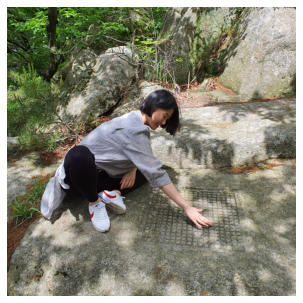

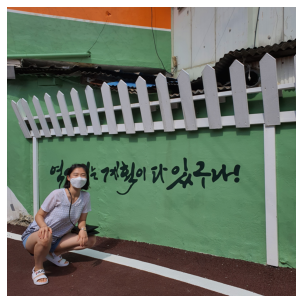

(3024, 3024, 3)
(3024, 3024, 3)


In [2]:
# 인물모드할 사진을 골라서 파일에 옮겨주기
img_path_1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_img_1.jpg'
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_img_2.jpg'

img1 = cv2.imread(img_path_1) 
img2 = cv2.imread(img_path_2) 

def with_pic(img):
    fig = plt.figure(figsize=(30,30))
    rows = 1
    cols = 5

    ax = fig.add_subplot(rows, cols, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # cv는 BGR로 나오므로 변환.
    plt.axis("off") # 축 제거.

with_pic(img1)
with_pic(img2)

plt.show()
print(img1.shape)
print(img2.shape)

*****

# Step 2. 모델 구현

- 구글에서 제공하는 모델 구조를 가지고 와서 ```DeepLabModel```클래스 생성.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지 전처리. 
    # Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) # 적당한 크기로 resize.
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image) # 전처리된 이미지는 run()의 입력값.

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# 모델 정의 및 모델 다운로드(DeepLabV3-PASCAL VOC 2012 데이터셋으로 학습 완료).
# 사전 학습된 가중치 다운로드(deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight).
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj20/aiffel/human_segmentation/models
model loaded successfully!


*****

# Step 3. 세그멘테이션 검출하기

In [5]:
# 이미지를 네트워크에 입력.
img_resized_1, seg_map_1 = MODEL.run(img1)
img_resized_2, seg_map_2 = MODEL.run(img2)
print (img1.shape, img_resized_1.shape, seg_map_1.max())
print (img2.shape, img_resized_2.shape, seg_map_2.max())

(3024, 3024, 3) (513, 513, 3) 15
(3024, 3024, 3) (513, 513, 3) 15


- cv2는 채널을 HWC 순서로 표시.
- seg_map의 15는 person을 의미.

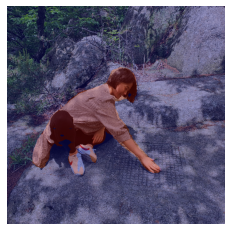

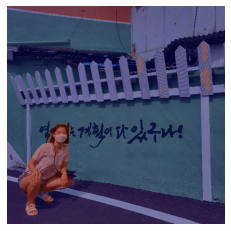

In [6]:
img_show_1 = img_resized_1.copy()
seg_map_1 = np.where(seg_map_1 == 15, 15, 0) # 예측 중 사람만 추출
img_mask_1 = seg_map_1 * (255/seg_map_1.max()) # 255 normalization
img_mask_1 = img_mask_1.astype(np.uint8)
color_mask_1 = cv2.applyColorMap(img_mask_1, cv2.COLORMAP_JET)
img_show_1 = cv2.addWeighted(img_show_1, 0.6, color_mask_1, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

img_show_2 = img_resized_2.copy()
seg_map_2 = np.where(seg_map_2 == 15, 15, 0) # 예측 중 사람만 추출
img_mask_2 = seg_map_2 * (255/seg_map_2.max()) # 255 normalization
img_mask_2 = img_mask_2.astype(np.uint8)
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET)
img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

*****

# Step 4. 세그멘테이션 결과 크기 복원하기

- 보간법(interpolation)은 이미지의 크기를 변경하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법.

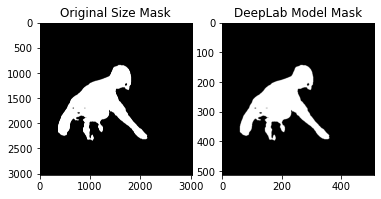

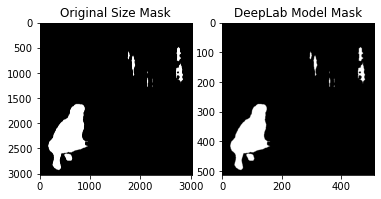

In [7]:
img_mask_up_1 = cv2.resize(img_mask_1, img1.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_1 = cv2.threshold(img_mask_up_1, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_1, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_1, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

img_mask_up_2 = cv2.resize(img_mask_2, img2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_2 = cv2.threshold(img_mask_up_2, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# Step 5. 배경 흐리게 만들기

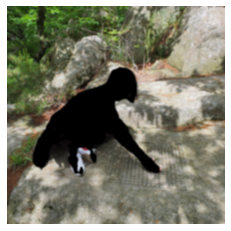

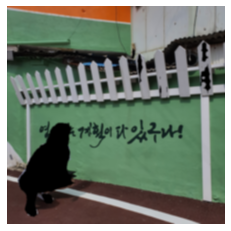

In [8]:
# 세그멘테이션 마스크만 이용해서 배경 추출.
img_mask_color_1 = cv2.cvtColor(img_mask_up_1, cv2.COLOR_GRAY2BGR)
img_bg_mask_1 = cv2.bitwise_not(img_mask_color_1) # 배경은 255, 사람은 0(이미지 반전).
img_bg_1 = cv2.bitwise_and(img1, img_bg_mask_1) # 배경만 있는 사진.

img_bg_blur_1 = cv2.blur(img_bg_1, (30,30)) # 블러 처리.
plt.imshow(cv2.cvtColor(img_bg_blur_1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

img_mask_color_2 = cv2.cvtColor(img_mask_up_2, cv2.COLOR_GRAY2BGR)
img_bg_mask_2 = cv2.bitwise_not(img_mask_color_2) # 배경은 255, 사람은 0(이미지 반전).
img_bg_2 = cv2.bitwise_and(img2, img_bg_mask_2) # 배경만 있는 사진.

img_bg_blur_2 = cv2.blur(img_bg_2, (30,30)) # 블러 처리.
plt.imshow(cv2.cvtColor(img_bg_blur_2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

*****

# Step 6. 배경과 원본 합성하기

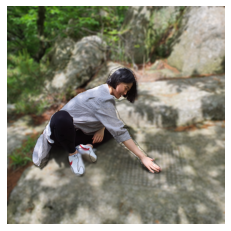

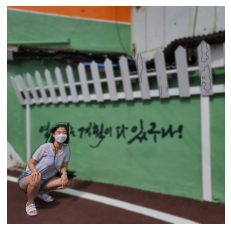

In [9]:
# 세그멘테이션 마스크 == 255인 부분만 원본에서 가져오고, 나머지는 블러 이미지 사용.
img_concat_1 = np.where(img_mask_color_1 ==255, img1, img_bg_blur_1)
plt.imshow(cv2.cvtColor(img_concat_1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

img_concat_2 = np.where(img_mask_color_2 ==255, img2, img_bg_blur_2)
plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'blurred')

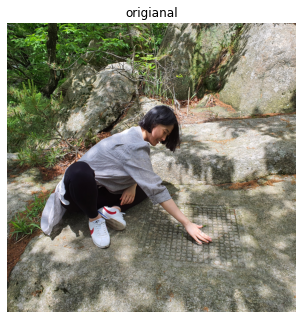

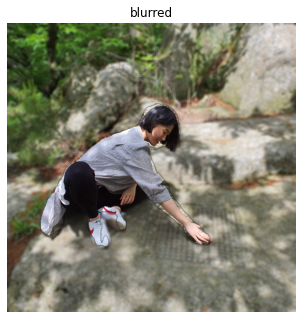

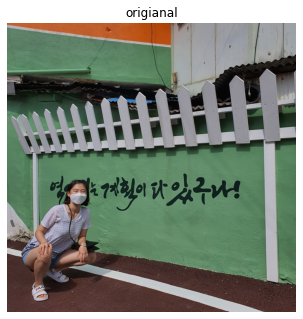

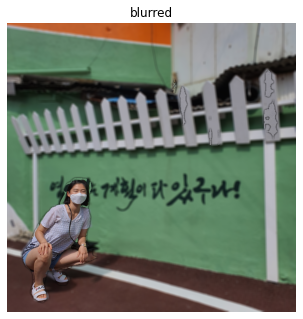

In [10]:
# 원본 이미지와 비교.
with_pic(img1) # 원본.
plt.title('origianal')
with_pic(img_concat_1) # 블러.
plt.title('blurred')

with_pic(img2) # 원본
plt.title('origianal')
with_pic(img_concat_2) # 블러
plt.title('blurred')

*****

# Step 7. 크로마키로 여행하기

## 인도에 다녀왔습니다!
(엣헴... 이번이 3번째 방문이네요.)

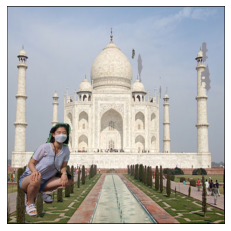

In [14]:
from PIL import Image
bg_1 = Image.open(os.getenv('HOME')+"/aiffel/human_segmentation/images/tajmahal.jpg")
bg_1_size = bg_1.resize((3024,3024))

img_concat_1 = np.where(img_mask_color_2 ==255, 
                        cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), 
                        bg_1_size)

plt.imshow(img_concat_1)
plt.axis("off")
plt.show()

## 이탈리아에 다녀왔습니다!
(제가 안 밀었어요. 원래 저렇답니다.)

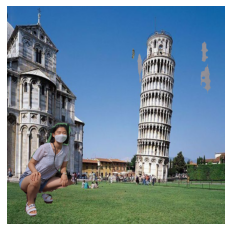

In [15]:
bg_2 = Image.open(os.getenv('HOME')+"/aiffel/human_segmentation/images/pisa.jpeg")
bg_2_size = bg_2.resize((3024,3024))

img_concat_2 = np.where(img_mask_color_2 ==255, 
                        cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), 
                        bg_2_size)

plt.imshow(img_concat_2)
plt.axis("off")
plt.show()

## 프랑스에 다녀왔습니다!
(생각보다 에펠탑이 작네요.)

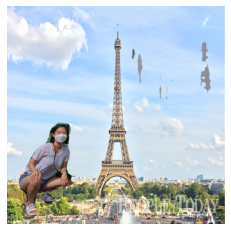

In [16]:
bg_3 = Image.open(os.getenv('HOME')+"/aiffel/human_segmentation/images/aiffeltower.jpg")
bg_3_size = bg_3.resize((3024,3024))

img_concat_3 = np.where(img_mask_color_2 ==255, 
                        cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), 
                        bg_3_size)

plt.imshow(img_concat_3)
plt.axis("off")
plt.show()

## 이 시국에 전세계를 여행한 방법은?
(달리 방법이 없어서 순간이동으로 다녀왔습니다.)

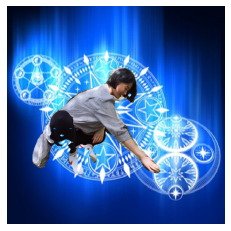

In [17]:
bg_4 = Image.open(os.getenv('HOME')+"/aiffel/human_segmentation/images/magic.jpg")
bg_4_size = bg_4.resize((3024,3024))

img_concat_4 = np.where(img_mask_color_1 ==255, 
                        cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), 
                        bg_4_size)

plt.imshow(img_concat_4)
plt.axis("off")
plt.show()

*****

# Step 8. 고양이 사진에 인물모드 적용하기

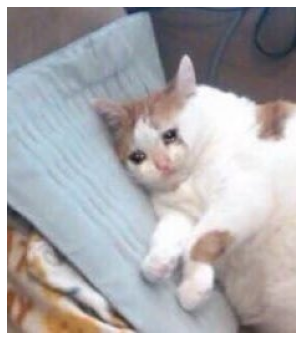

(262, 232, 3)


In [18]:
# 사진 불러오기.
img_path_3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_img_1.jpg'

img3 = cv2.imread(img_path_3) 

with_pic(img3)

plt.show()
print(img3.shape)

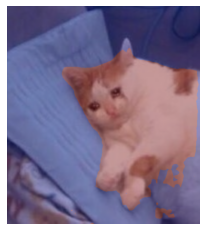

In [19]:
# 세그멘테이션 검출하기
img_resized_3, seg_map_3 = MODEL.run(img3)

img_show_3 = img_resized_3.copy()
seg_map_3 = np.where(seg_map_3 == 8, 8, 0) # 예측 중 고양이만 추출.
img_mask_3 = seg_map_3 * (255/seg_map_3.max()) # 255 normalization.
img_mask_3 = img_mask_3.astype(np.uint8)
color_mask_3 = cv2.applyColorMap(img_mask_3, cv2.COLORMAP_JET)
img_show_3 = cv2.addWeighted(img_show_3, 0.6, color_mask_3, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

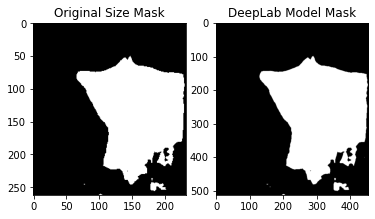

In [20]:
# 세그멘테이션 결과 크기 복원하기
img_mask_up_3 = cv2.resize(img_mask_3, img3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_3 = cv2.threshold(img_mask_up_3, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_3, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

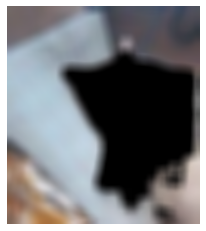

In [21]:
# 세그멘테이션 마스크만 이용해서 배경 추출.
img_mask_color_3 = cv2.cvtColor(img_mask_up_3, cv2.COLOR_GRAY2BGR)
img_bg_mask_3 = cv2.bitwise_not(img_mask_color_3) # 배경은 255, 고양이는 0(이미지 반전).
img_bg_3 = cv2.bitwise_and(img3, img_bg_mask_3) # 배경만 있는 사진.

img_bg_blur_3 = cv2.blur(img_bg_3, (15,15)) # 블러 처리.
plt.imshow(cv2.cvtColor(img_bg_blur_3, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## 고양이 인물모드 완성

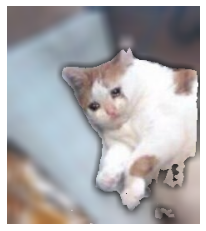

In [22]:
# 배경 원본과 합성하기
img_con_cat_1 = np.where(img_mask_color_3 ==255, img3, img_bg_blur_3)
plt.imshow(cv2.cvtColor(img_con_cat_1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## 우주 고양이

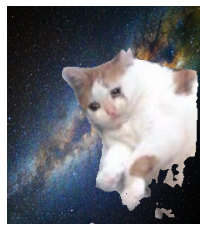

In [23]:
# 고양이로 크로마키하기
bg_cat_4 = Image.open(os.getenv('HOME')+"/aiffel/human_segmentation/images/space.jpg")
bg_cat_4_size = bg_cat_4.resize((232, 262))

img_con_cat_4 = np.where(img_mask_color_3 ==255, 
                        cv2.cvtColor(img3, cv2.COLOR_BGR2RGB), 
                        bg_cat_4_size)

plt.imshow(img_con_cat_4)
plt.axis("off")
plt.show()

## 마법 고양이

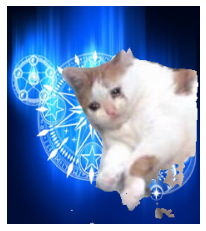

In [24]:
bg_cat_5 = Image.open(os.getenv('HOME')+"/aiffel/human_segmentation/images/magic.jpg")
bg_cat_5_size = bg_cat_5.resize((232, 262))

img_con_cat_5 = np.where(img_mask_color_3 ==255, 
                        cv2.cvtColor(img3, cv2.COLOR_BGR2RGB), 
                        bg_cat_5_size)

plt.imshow(img_con_cat_5)
plt.axis("off")
plt.show()

*****

# Step 9. 사진에서 문제점 찾기

## 문제 1. 인식이 되지 않아야 할 부분이 인식 됨.

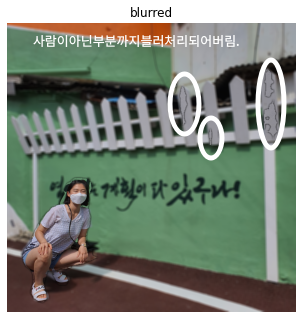

In [36]:
from IPython.display import Image
Image("/home/aiffel-dj20/aiffel/human_segmentation/images/my_blurred_2.png")

## 문제 2. 인식되어야 할 부분이 인식되지 않음.

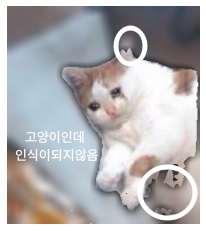

In [37]:
Image("/home/aiffel-dj20/aiffel/human_segmentation/images/cat_blurred.png")

*****

# Step 10. 해결 방안 제안해보기

> **<아웃포커싱의 원리>**     
> **렌즈는 빛을 굴절시켜 필름에 영사시키게 하고, 렌즈는 앞뒤로 왔다갔다 하면서 초점을 잡음.**     
> **그런데 피사체가 가까이 있으면 피사체의 초첨은 잡지만 배경은 미쳐 잡지 못하고 영사됨.**    
> **그래서 아웃포커싱이 잘 되려면 피사체를 가까이 두고 조리개는 열고, 셔터 스피드는 느리게 하여 빛이 렌즈 속으로 많이 들어오게 함.**    

> **<피사계심도>**       
> **사진술에서 한 사진의 초점이 맞은 것으로 인식되는 범위.**    
> **얕은 피사계심도로 찍은 사진은 아웃포커싱 됨. --> 빛을 많이 받은 사진.**

## <해결 방안>    
**사진에서 블러 처리가 되지 말아야 하는 부분이 블러 처리가 되는 문제나, 블처 처리가 되어야 하는 부분이 되지 않는 문제는 '인간이 사물을 보는 방식'을 적용하면 해결할 수 있다고 생각한다.**         
**인간의 눈은 두개이다. 그래서 눈에 모래나 거품이 한쪽 눈에 들어가서 한쪽 눈만 뜨고 있을 수 있을 때 우린 굉장한 불편함을 느낀다. 한쪽 눈만 사용하면 원근감이 떨어지고 입체감을 잘 느낄 수 없다.**    
**우리가 물체와의 거리를 알 수 있는 것은 두 눈과 물체를 잇는 두 직선 사이에 광각이 형성되어 있기 때문이다. 그리고 우리가 물체의 크고 작음을 입체적으로 느낄 수 있는 것은 물체의 양쪽 끝에서 눈에 이르는 두 직선 사이에 시각이 형성되기 때문이다. 눈이 하나라면 광각, 시각 모두 형성될 수 없다.**    
**1개의 카메라로 찍은 사진도 마찬가지라고 생각한다. 1개의 카메라로 찍은 사진은 거리와 물체의 크기를 인식하기 어렵다고 생각한다. 그래서 3D Depth camera의 스테레오 방식을 사용하면 인간이 사물을 인식하는 것과 같이 더 정확하게 사물을 인식하고 세그멘테이션 마크를 할 수 있을 것 같다.**    


**사실 3D Depth camera의 스테레오 방식을 다 이해한 것은 아니다. 나는 피사계심도의 의미를 찾아보고나서 문득 사람이 물체를 인식하는 방법을 적용하면 더 나은 결과를 낼 수 있지 않을까 생각했다. 그러고 나서 블로그를 통해 3D Depth camera의 스테레오 방식을 그린 그림을 보았다. 내 생각과 정말 비슷했다.**    
**3D Depth camera의 스테레오 방식은 픽셀의 깊이 정보까지 알 수 있다고 하지만 나는 그 정도까지는 필요없다고 생각한다. 인간의 눈은 오른쪽 눈과 왼쪽 눈이 6~7cm 떨어져 있어 약간 다른 각도로 사물을 바라보게 된다. 이때 뇌의 시각중추가 두 개의 형상을 결합하거나 재구성해서 하나의 3차원 입체로 보이게 한다.**    
**내가 주목한 점은 가까운 물체를 볼때이다. 가까운 물체에 집중하면 집중하고 있는 물체는 하나의 입체로 또렷하게 보이지만 뒤에 배경은 두 개로 나뉘어보인다. 특히 여기서 중요한 것은 집중이다.**    
**프로그램으로 어떻게 구현할지는 잘 모르겠지만 같은 높이에 있지만 왼쪽과 오른쪽으로 위치해 있는 2개의 카메라를 가지고 2장의 사진을 찍는다. 그리고 집중하고 싶은 부분에 포커스를 두고 세그멘테이션을 하면 포커스를 둔 부분이 더 확실하게 마킹되지 않을까?**     

**한계점은 '사진 자체에 어떻게 포커스된 정보를 남길 것인지'인 것 같다.**

*****

# 루브릭 평가


|평가문항|상세기준|
|:------|:------|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

**1. 인물사진 모드는 성공적으로 제작했다. 고양이 사진도 인물사진 모드로 잘 제작했다고 생각한다. 그리고 블러된 배경 대신 가고 싶은 나라의 랜드마크 사진들을 크로마키로 합성해서 모두가 감쪽같이 속을(?) 여행사진도 성공적으로 만들었다.**    

**2. 크로마키를 하고 나서 세그멘테이션을 사용한 인물사진 모드의 문제점을 확연하게 알 수 있었다. 세그멘테이션 마크가 되어야 할 부분은 되지 않고, 되지 말아야 할 부분은 되는 문제들을 발견할 수 있었다.**    

**3. 솔직히 솔루션은 제대로 제시하지 못한 것 같다. 카메라 2대라는 것이 인간의 두 눈과 비슷한 것 같아서 인간의 가까운 사물인식 과정을 접목해보고 싶었다. 머릿속에서는 될 것 같은데 말로 풀려니 여간 어려운 것이 아니었다. 원래 있는 기법인데 내가 있는 줄 모르는 것일 수도 있다.**

# 회고

**정말 재밌는 프로젝트였다. 합성이라는 요소가 들어있어서 그런 것 같다. 어제 12시까지만 하고 자려고 했는데 뒤늦게 고양이과 크로마키가 있다는 것을 알고 만들어내느라 1시가 넘어서야 잠자리에 들었다. 사실 제출마감일에 했어도 되는데 하다보니까 재밌어서 그만둘 수 가 없었다. 나는 자연어 처리반을 선택했는데 왜이리 CV에 재미를 느끼는 건지 모르겠다. 아, 이미 자연어 처리로 가고자 마음먹어서 더 재밌는 건가?**
**세그멘테이션이라는 것은 정말 신기했다. 어떻게 알고 설정한 카테고리에 있는 부분을 마크하는지 모르겠다. 아, 어떻게 돌아가는지는 이해했는데 신기하다는 말이다. 조금만 더하면 누끼를 따는 작업은 인간이 안해도 되겠다 싶다. 어도비 포토샾에 누끼를 따주는 동작이 있는 것으로 알고 있는데, 거기에 세그멘테이션이 적용된 것인지 아닌지는 좀 궁금하다.**    